In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as pyplot
import shapely
import geopandas
import pandas
import numpy as np
from pathlib import Path
import fiona
import pytess

## Assignment GISC425 - Voronoi Polygons
### Ollie Blake and Esther van Vliet

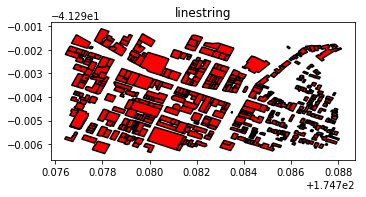

In [12]:
#In this first section we convert out polygons into lines by taking the boundary of the building polygons

expol = geopandas.read_file("buildings.shp") #<---CHANGE TO OWN DIRECTORY
x = expol.geometry.boundary #Gets the boundaries of the polygons
expol.geometry = x
fig = pyplot.figure(figsize=(12,12))

ax1 = fig.add_subplot(221)
ax1.set_title("linestring")
expol.plot(ax=ax1, facecolor='Red', edgecolor='Black')

expol = expol[['osm_id', 'geometry']] #taking data we need

#Make shape file
out=Path("polyboundary.shp") # <---CHANGE THIS TO OWN DIRECTORY
expol.to_file(out)

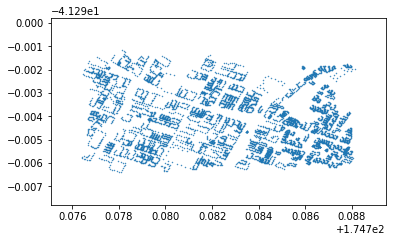

In [14]:
#In this block we are converting the boundary lines we made above into points

bpol = geopandas.read_file("polyboundary.shp") #<---CHANGE TO OWN DIRECTORY

lpdata=geopandas.GeoDataFrame() #creating GDF to store the points
lpdata['geometry']=None
lpdata['bound']=None

#This loops through the line file and creates points down the linestring
p=0 
for i in range(len(bpol)):
    line_string=bpol.geometry[i] 
    for k in np.arange(0.1, 0.9, 0.05): #Creates a point at every 5th percent of the line
        ip=line_string.interpolate(k, normalized=True) #Creates the point
        lpdata.loc[p, 'geometry']=ip #Add geometry of point to lpdata set
        lpdata.loc[p, 'bound']=bpol['osm_id'][i] #Links id of the polyboundary that the point is on to the point in lpdata set
        p+=1

out=Path("polypoints.shp") #<---CHANGE TO OWN DIRECTORY
lpdata.to_file(out) 

lpdata.plot(markersize=0.2)

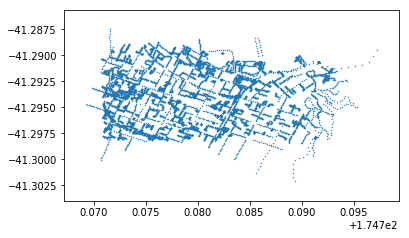

In [16]:
#Here we are doing the same thing as above, but with street data which is already in a linestring
#We need to convert this into points

streets=geopandas.read_file('streets.shp') #<---CHANGE TO OWN DIRECTORY

lpdata1=geopandas.GeoDataFrame() #Once again creating a GDF to store the points 
lpdata1['geometry']=None
lpdata1['street']=None

p=0 #same loop as above
for i in range(len(streets)):
    line_string=streets.geometry[i]
    for k in np.arange(0.1, 0.9, 0.05): #Creates a point at every 5th percent of the line
        ip=line_string.interpolate(k, normalized=True)
        lpdata1.loc[p, 'geometry']=ip #Add geometry of point to lpdata set
        lpdata1.loc[p, 'street']=streets['osm_id'][i] #Links id of the street of the point to the point in lpdata set
        p+=1
        
out=Path("linepointstreet.shp") #<---CHANGE TO OWN DIRECTORY
lpdata1.to_file(out)

lpdata1.plot(markersize=0.2)

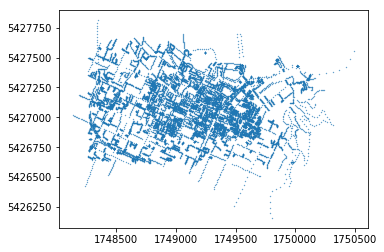

In [17]:
#Here we have three point files:
# - bus stops imported from QGIS
# - points along the streets
# - points along the boundaries of buildings
#We want to merge each shapefile together to create one file with all points within it

pnt = geopandas.read_file("bus_stops.shp") #<---CHANGE TO OWN DIRECTORY
lpnt = geopandas.read_file("linepointstreet.shp") #<---CHANGE TO OWN DIRECTORY
ppnt = geopandas.read_file("polypoints.shp") #<---CHANGE TO OWN DIRECTORY

#Below we are adding in a common field called id. This links points to either their bus stop id, their street id, or their building id.
#This is needed for the dissolving step later on.
ppnt['id']=ppnt['bound']
lpnt['id']=lpnt['street']
pnt['id']=pnt['osm_id']

#Create the one GDF from the three above, and convert them all to the same projection (NZTM)
allpnt = pandas.concat([ppnt, lpnt, pnt], sort=True, ignore_index=True)
allpnt.crs = pnt.crs
allpnt = allpnt.to_crs({'init': 'epsg:2193'})

allpnt.plot(markersize=.1)

In [19]:
#Now we can make our voronoi polygons for each point from the variable allpnt

allpnt['x'] = allpnt['geometry'].x
allpnt['y'] = allpnt['geometry'].y
#Makes an array out of the GDF, the voronoi function will only work with this type of data array
points_array=np.array([[allpnt['x'][k], allpnt['y'][k]] for k in range(len(allpnt))])

#Using the pytess function to create the voronoi polygons
voronois = pytess.voronoi(points_array)
#Below we are creating an empty list to put the polygon data into.
#The loop removes the point data and leaves us with only polygons' geometry (thanks David!)
vorpolys = []
for pt, poly in voronois:
    vorpolys.append(shapely.geometry.Polygon(poly))

In [20]:
#Lastly, we need to dissolve the data by the ID field that we created earlier
#This will join each individual building and street voronoi polygons, so that each street/building has one voronoi
#Create a GDF from the voronoi polygons
poly_df = geopandas.GeoDataFrame(geometry=geopandas.GeoSeries(vorpolys))
poly_df.crs = allpnt.crs

#Spatially join the polygons to the origional point data, so the id field can be carried over
#It creates a dataset with the allpnt and the matched voronoi polygons (by using 'contains' option) 
voronois_df=geopandas.sjoin(poly_df, allpnt, how='left', op='contains')

#We create a buffer around the polygons because the polygons intersect and the dissolve won't work
voronois_df['geometry'] = voronois_df.buffer(0.01)
#Finally perform the dissolve to make the separate voronois for each building and street whole once again!
voronois_dissolv=voronois_df.dissolve(by='id')

#Put the output in a new shapefile
out=Path("VoronoisDissolved.shp") #CHANGE TO OWN DIRECTORY
voronois_dissolv.to_file(out)

(5426800, 5427200)

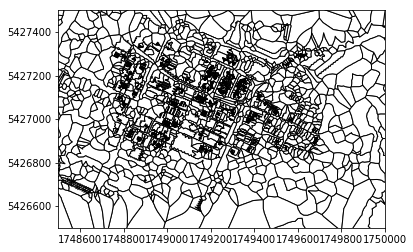

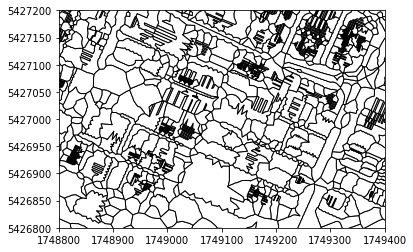

In [90]:
#Now we can plot our voronoi polygons!

voronois_dissolv.plot(markersize=.1, facecolor="white", edgecolor='black')
pyplot.xlim(1748500, 1750000)
pyplot.ylim(5426500, 5427500)

voronois_dissolv.plot(markersize=.1, facecolor="white", edgecolor='black')
pyplot.xlim(1748800, 1749400)
pyplot.ylim(5426800, 5427200)


(5426800, 5427000)

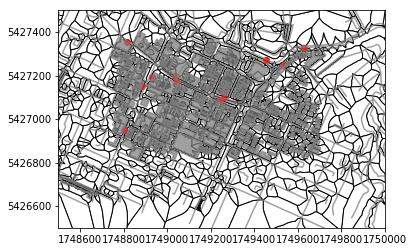

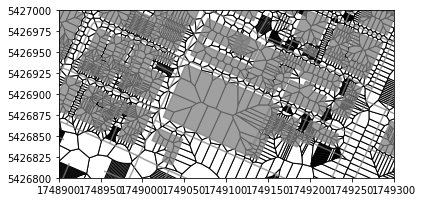

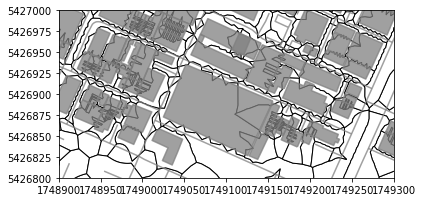

In [96]:
#Now we will plot the voronois on top of the buildings, streets and busstops
#Convert bus stops, streets and buildings to the same projection (NZTM)
pnt = pnt.to_crs({'init': 'epsg:2193'}) #for plotting busstops 
streets = streets.to_crs({'init': 'epsg:2193'}) #for plotting streets
expol = expol.to_crs({'init': 'epsg:2193'}) #for plotting buildings

#This plots it for Wellington
fig = pyplot.figure()
base=fig.add_subplot(111)
streets.plot(ax=base, edgecolor='Grey', alpha=.75)
expol.plot(ax=base, facecolor='Grey', edgecolor='Grey', alpha=.75)
voronois_dissolv.plot(ax=base, markersize=.1, facecolor="white", edgecolor='black')
pnt.plot(ax=base, color='Red')
pyplot.xlim(1748500, 1750000)
pyplot.ylim(5426500, 5427500)

#This plots the voronois for all points for a smaller part of town on top of the buildings, streets, and busstops
fig=pyplot.figure()
base2=fig.add_subplot(111)
streets.plot(ax=base2, edgecolor='Grey', alpha=.75)
expol.plot(ax=base2, facecolor='Grey', edgecolor='Grey', alpha=.75)
pnt.plot(ax=base3, color='Red')
poly_df.plot(ax=base2, facecolor='white', edgecolor='black')
pyplot.xlim(1748900, 1749300)
pyplot.ylim(5426800, 5427000)

#This plots the merged voronois for each building, street, and bus stop for a smaller part of town 
fig=pyplot.figure()
base3=fig.add_subplot(111)
streets.plot(ax=base3, edgecolor='Grey', alpha=.75)
expol.plot(ax=base3, facecolor='Grey', edgecolor='Grey', alpha=.75)
voronois_dissolv.plot(ax=base3, markersize=.1, facecolor='white', edgecolor='black')
pnt.plot(ax=base3, color='Red')
pyplot.xlim(1748900, 1749300)
pyplot.ylim(5426800, 5427000)

The script works, but the last plots show that it is not perfect. The zigzagging voronois could be due to the fact that there is only a point created at the street/polyboundary at each 5th percent. It would be better to have more points, but this was unfeasible, because it made the program very slow. 